# Nettoyage et Analyse du dataset ASSURAIMANT


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#statsmodel
#Parameter "stratify" from method "train_test_split"

# testsize0.2
# randomstate42

In [2]:
data = pd.read_csv('data/4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv')
data.head()
df = data.copy()

#### Présentation du dataset : 
- **Nombre d'entrées** :  1338
- **Colonnes et type** : 
    - ` age ` :    `int64`  <span style="color: green;"> (variable continue) </span> 
    - `sex`   :    `object` <span style="color: green;"> (variable catégorielle binaire) </span> 
    - `bmi`   :    `float64` <span style="color: green;"> (variable continue) </span> 
    - `children`  :   `int64` <span style="color: green;"> (variable discrète) </span> 
    - `smoker`    :   `object` <span style="color: green;"> (variable catégorielle binaire) </span> 
    - `region`    :   `object` <span style="color: green;"> (variable catégorielle) </span> 
    - `charges`   :   `float64` <span style="color: green;"> (variable continue) </span> 

### Vérification de valeurs manquantes (A) et des doublons (B)

In [3]:
#msno.bar(df)    Utilisation possible de la librairie missingno
print(data.isnull().sum())
print('(A) : Aucune valeur manquante sur le dataset')

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
(A) : Aucune valeur manquante sur le dataset


In [4]:
# Identifier les lignes dupliquées
duplicates = data[data.duplicated()]
print(f" - (B) Nombre de doublons dans le dataset : {len(duplicates)}")
print(f" - Liste des doublons : \n{duplicates}")
data.drop_duplicates()

 - (B) Nombre de doublons dans le dataset : 1
 - Liste des doublons : 
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Analyse univariée
#### A. Variables numériques

In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


/tmp/ipykernel_161672/3578885433.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


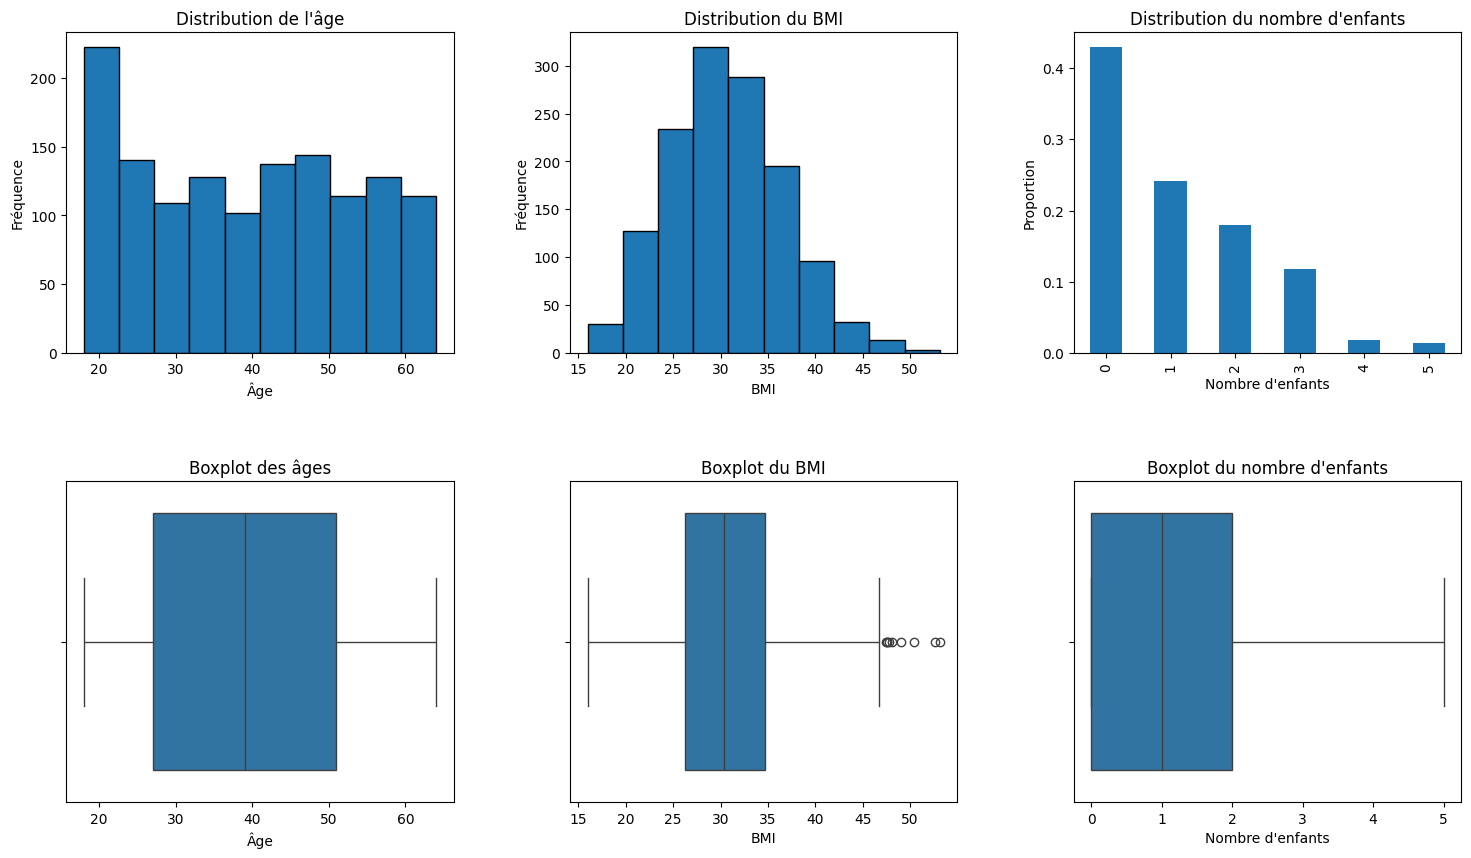

<Figure size 640x480 with 0 Axes>

In [6]:
# Création de la figure avec des dimensions ajustées
fig, axes = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# 1er graphique : Distribution de l'âge
axes[0, 0].hist(data['age'], bins=10, edgecolor='black')
axes[0, 0].set_title("Distribution de l'âge")
axes[0, 0].set_xlabel("Âge")
axes[0, 0].set_ylabel("Fréquence")

# 2ème graphique : Distribution du BMI
axes[0, 1].hist(data['bmi'], bins=10, edgecolor='black')
axes[0, 1].set_title("Distribution du BMI")
axes[0, 1].set_xlabel("BMI")
axes[0, 1].set_ylabel("Fréquence")

# 3ème graphique : Distribution des enfants
data["children"].value_counts(normalize=True).plot(kind='bar', width=0.5, ax=axes[0, 2])
axes[0, 2].set_title("Distribution du nombre d'enfants")
axes[0, 2].set_xlabel("Nombre d'enfants")
axes[0, 2].set_ylabel("Proportion")

# 4ème graphique : Boxplot des âges
sns.boxplot(x=data['age'], ax=axes[1, 0])
axes[1, 0].set_title("Boxplot des âges")
axes[1, 0].set_xlabel("Âge")

# 5ème graphique : Boxplot du BMI
sns.boxplot(x=data['bmi'], ax=axes[1, 1])
axes[1, 1].set_title("Boxplot du BMI")
axes[1, 1].set_xlabel("BMI")

# 6ème graphique : Boxplot des enfants
sns.boxplot(x=data['children'], ax=axes[1, 2])
axes[1, 2].set_title("Boxplot du nombre d'enfants")
axes[1, 2].set_xlabel("Nombre d'enfants")

# Ajustement de la mise en page
plt.tight_layout()
plt.show()

plt.savefig(f'plots/hist_variables_num', dpi=300, bbox_inches='tight')


#### Gestion des outliers : 
Quelques valeurs de bmi sont en dehors de la boxplot (> valeur max) et sont donc considérées comme **outliers**.
Dans notre cas, nous choisissons de conserver les données qui restent **réalistes**.

In [7]:
# Calcul des quartiles
Q1 = data['bmi'].quantile(0.25)
Q3 = data['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Calcul des limites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Détection des valeurs aberrantes
outliers = data[(data['bmi'] < lower_bound) | (data['bmi'] > upper_bound)]

print(f"Valeurs aberrantes (n = {len(outliers)}) :")
print((outliers.bmi))


Valeurs aberrantes (n = 9) :
116     49.06
286     48.07
401     47.52
543     47.41
847     50.38
860     47.60
1047    52.58
1088    47.74
1317    53.13
Name: bmi, dtype: float64


### B. Variables catégorielles

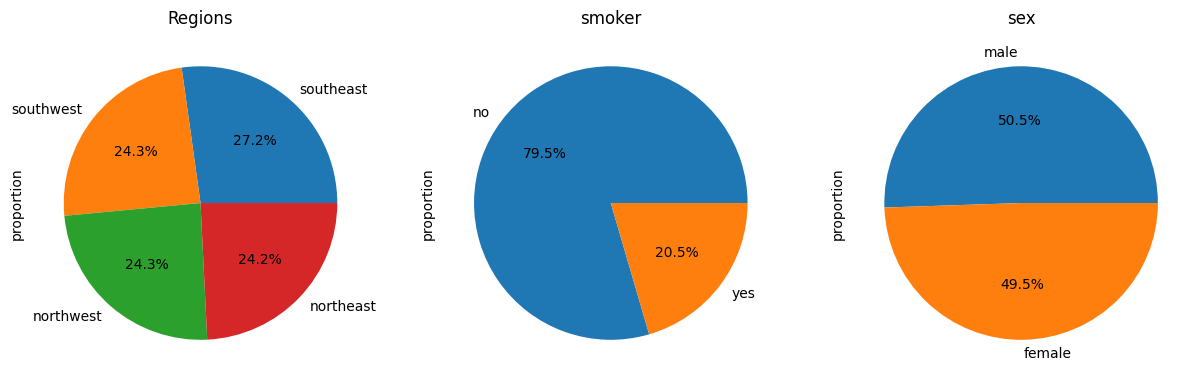

In [8]:
# Création des graphiques
plt.figure(figsize=(15, 5))

# Pie chart pour les régions (avec autopct)
plt.subplot(131)
data["region"].value_counts(normalize=True).plot(kind='pie',  autopct='%1.1f%%')
plt.title("Regions")

plt.subplot(132)
data["smoker"].value_counts(normalize=True).plot(kind='pie',  autopct='%1.1f%%')
plt.title("smoker")

plt.subplot(133)
data["sex"].value_counts(normalize=True).plot(kind='pie',  autopct='%1.1f%%')
plt.title("sex")
plt.savefig(f'plots/pie_charts_categorielles', dpi=300, bbox_inches='tight')

# Sauvegarde et affichage
plt.savefig('plots/pie_charts_categorielles.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# # Initialiser le OneHotEncoder
# encoder = OneHotEncoder(parse=False, drop='first')

# # Appliquer sur les colonnes Région, smoker, sex
# encoded_data = encoder.fit_transform(data[['sex']])

# data.head()

In [10]:
data["masculin"] = data["sex"].apply(lambda x: 1 if x == "male" else 0)
data["feminin"] = data["sex"].apply(lambda x: 1 if x == "female" else 0)
data["southwest"] = data["region"].apply(lambda x: 1 if x == "southwest" else 0)
data["northwest"] = data["region"].apply(lambda x: 1 if x == "northwest" else 0)
data["northeast"] = data["region"].apply(lambda x: 1 if x == "northeast" else 0)
data["southeast"] = data["region"].apply(lambda x: 1 if x == "southeast" else 0)
data["smoker"] = data["smoker"].apply(lambda x: 1 if x == "yes" else 0)
data = data.drop(columns=['sex', 'region'])
data.head()

,age,bmi,children,smoker,charges,masculin,feminin,southwest,northwest,northeast,southeast
0,19,27.900,0,1,16884.92400,0,1,1,0,0,0
1,18,33.770,1,0,1725.55230,1,0,0,0,0,1
2,28,33.000,3,0,4449.46200,1,0,0,0,0,1
3,33,22.705,0,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,0,3866.85520,1,0,0,1,0,0


### Corrélation des variables

In [11]:
data.head()

,age,bmi,children,smoker,charges,masculin,feminin,southwest,northwest,northeast,southeast
0,19,27.900,0,1,16884.92400,0,1,1,0,0,0
1,18,33.770,1,0,1725.55230,1,0,0,0,0,1
2,28,33.000,3,0,4449.46200,1,0,0,0,0,1
3,33,22.705,0,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,0,3866.85520,1,0,0,1,0,0


charges      1.000000
smoker       0.787251
age          0.299008
bmi          0.198341
southeast    0.073982
children     0.067998
masculin     0.057292
northeast    0.006349
northwest   -0.039905
southwest   -0.043210
feminin     -0.057292
Name: charges, dtype: float64


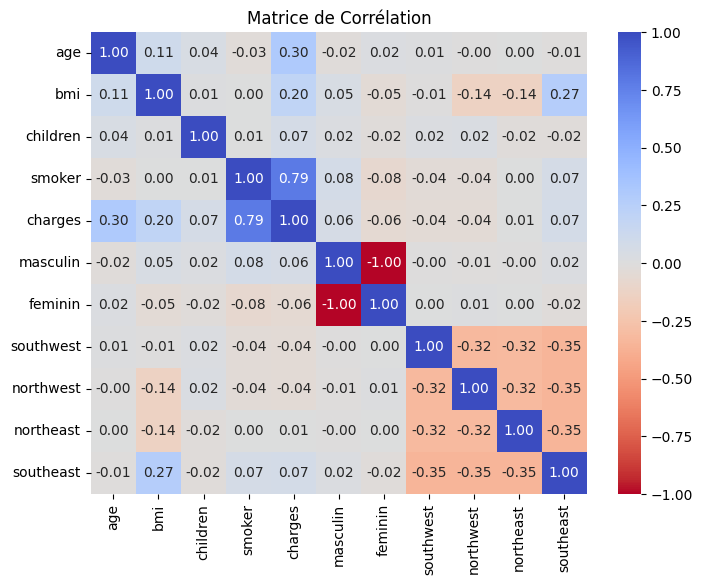

In [12]:

corr_matrix = data.corr()

# Afficher la corrélation avec la variable cible 'charges'
print(corr_matrix['charges'].sort_values(ascending=False))

# Affichage de la heatmap avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm_r", fmt=".2f", cbar=True)
plt.title("Matrice de Corrélation")
plt.savefig(f'plots/correlation_matrix', dpi=300, bbox_inches='tight')

plt.show()

#### Commentaires sur la matrice de corrélation : 
 - **colonnes corrélées avec la cible (charges)** :
 smoker (0.79) <span style="color: green;"> corrélation forte </span> **variable influente pour la régression**

 age (0.30) <span style="color: lightgreen;"> corrélation moyenne </span>

 bmi (0.20) <span style="color: lightgreen;"> corrélation moyenne </span>

children (0.07) <span style="color: yellow;"> corrélation faible </span> non utilisée pour la régression dans un premier temps

sex (+-0.08) <span style="color: yellow;"> corrélation faible </span> non utilisée pour la régression dans un premier temps
 - **colonnes non corrélées** : 

régions ([*-0.04*, *0.07*])    : <span style="color: red;"> corrélation nulle </span> **variable négligeable** non utilisée pour la régression 

**Conclusion** :

 - Nous utiliserons dans un premier temps les variables qui semblent le plus corrélées à notre cible : *smoker*, *age* et *bmi*.
 - Dans un second temps, nous ajouterons *children* et *sex* et régions (?) pour voir si cela améliore les performances du modèle

 - Pas de multicolinéarité entre **bmi et smoker**, **age et smoker**, faible entre **bmi et age** 


## Tests statistiques

### Tests de Pearson
mesure la relation linéaire entre deux variables continues [-1 +1].  0: relation nulle / (-) corrélation negative / (+) corrélation positive

In [13]:
# Test de Pearson entre charges et bmi
corr_bmi, p_value_bmi = stats.pearsonr(data["charges"], data["bmi"])

print(f"Corrélation charges-bmi : {corr_bmi:.4f}, p-value : {p_value_bmi:.4e}")

# Test de Pearson entre charges et age
corr_age, p_value_age = stats.pearsonr(data["charges"], data["age"])
print(f"Corrélation charges-age : {corr_age:.4f}, p-value : {p_value_age:.4e}")

# Test de Pearson entre charges et smoker
corr_smoker, p_value_smoker = stats.pearsonr(data["charges"], data["smoker"])
print(f"Corrélation charges-smoker : {corr_smoker:.4f}, p-value : {p_value_smoker:.4e}")

print('-'*50)
print('p-values << 0.05 : corrélation significative')
print('forte corrélation positive charges - smoker')
print('Corrélation positive modérée charges - (bmi, age)')


Corrélation charges-bmi : 0.1983, p-value : 2.4591e-13
Corrélation charges-age : 0.2990, p-value : 4.8867e-29
Corrélation charges-smoker : 0.7873, p-value : 8.2714e-283
--------------------------------------------------
p-values << 0.05 : corrélation significative
forte corrélation positive charges - smoker
Corrélation positive modérée charges - (bmi, age)


### Tests ANOVA
H0 = les moyennes des deux variables sont égales. H1 = 
Utiliser entre une variable continue et une variable catégorielle

- A: entre charge et fumeur
- B: entre bmi et fumeur
- C: entre age et fumeur
- D: charge et enfants

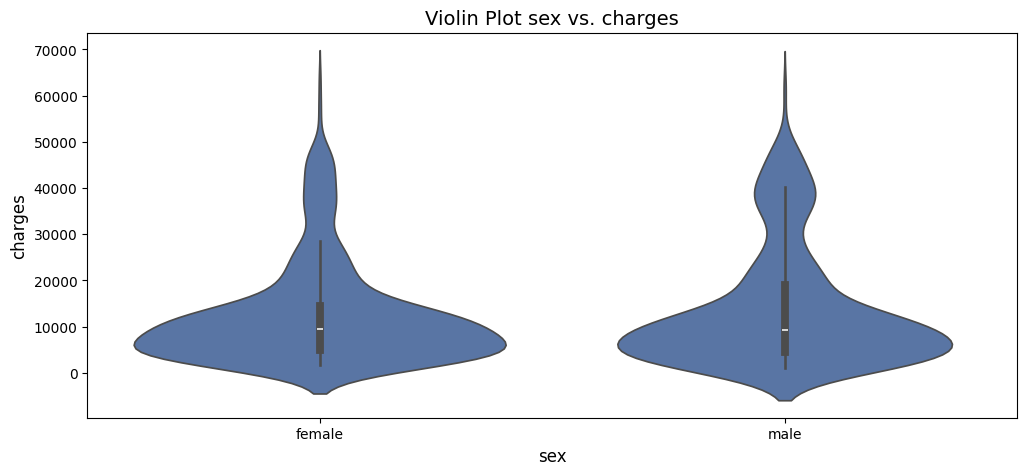

Ces écarts sont ils significatifs?
                sum_sq      df         F    PR(>F)
C(sex)    6.435902e+08     1.0  4.399702  0.036133
Residual  1.954306e+11  1336.0       NaN       NaN
0.03613272100596256<0.05 on rejette l'hypothese nulle. On considère qu'il y a un effet sur charges lié à sex
F-statistic  = 4.399701697437495 


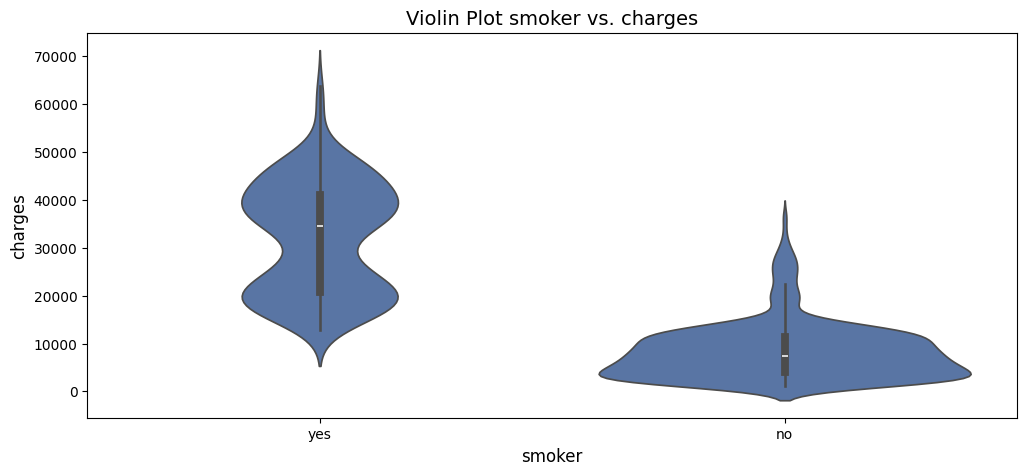

Ces écarts sont ils significatifs?
                 sum_sq      df            F         PR(>F)
C(smoker)  1.215199e+11     1.0  2177.614868  8.271436e-283
Residual   7.455432e+10  1336.0          NaN            NaN
8.271435842191429e-283<0.05 on rejette l'hypothese nulle. On considère qu'il y a un effet sur charges lié à smoker
F-statistic  = 2177.6148680565134 


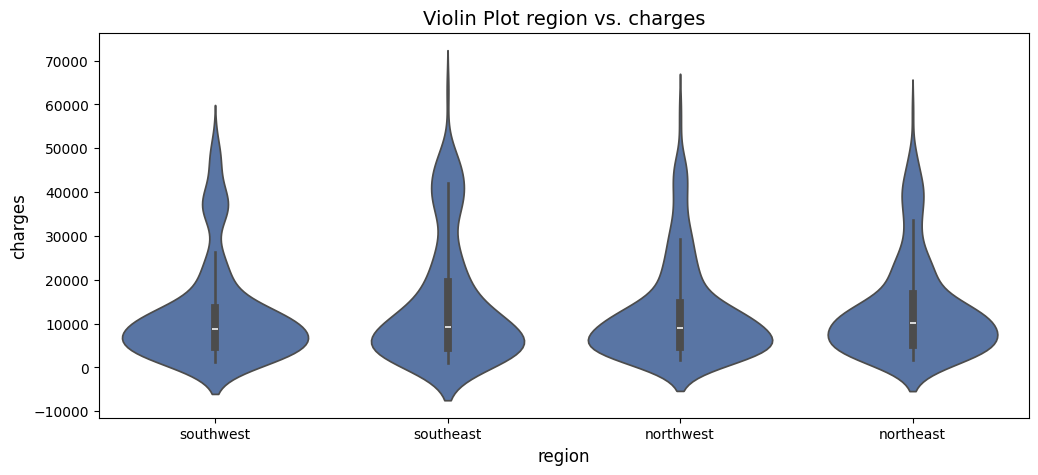

Ces écarts sont ils significatifs?
                 sum_sq      df         F    PR(>F)
C(region)  1.300760e+09     3.0  2.969627  0.030893
Residual   1.947735e+11  1334.0       NaN       NaN
0.0308933560705201<0.05 on rejette l'hypothese nulle. On considère qu'il y a un effet sur charges lié à region
F-statistic  = 2.96962669358911 


{'anova_table':                  sum_sq      df         F    PR(>F)
 C(region)  1.300760e+09     3.0  2.969627  0.030893
 Residual   1.947735e+11  1334.0       NaN       NaN,
 'F-statistic': np.float64(2.96962669358911),
 'p-value': np.float64(0.0308933560705201)}

In [14]:
def analyse_anova(x_continu:str,x_categorielle:str,data:pd.DataFrame):
    """
    Effectue une analyse ANOVA entre une variable continue et une variable catégorielle.
    Affiche un violin plot et retourne les résultats du ANOVA.

    Arguments : 
    x_continu = str, nom de la colonne de la variable continue
    x_catégorielle = str, nom de la colonne catégorielle
    data = DataFrame pandas

    Return : 
    dict contenant F-statistics et p-value
    """
    model = ols(f'{x_continu} ~ C({x_categorielle})', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    F_stats = anova_table.loc[f'C({x_categorielle})', 'F']
    p_value = anova_table.loc[f'C({x_categorielle})', 'PR(>F)']

    # Créer le violin plot
    plt.figure(figsize=(12, 5))
    # plt.subplot(121)
    sns.set_palette("deep")
    sns.violinplot(x=x_categorielle, y=x_continu, data=data)
    plt.title(f'Violin Plot {x_categorielle} vs. {x_continu}', fontsize=14)
    plt.xlabel(f'{x_categorielle}', fontsize=12)
    plt.ylabel(f'{x_continu}', fontsize=12)

    # plt.subplot(122)
    # sns.boxplot(x=x_categorielle, y=x_continu, data=data)
    # plt.title(f'Boxplot {x_categorielle} vs. {x_continu}', fontsize=14)
    # plt.xlabel(f'{x_categorielle}', fontsize=12)
    # plt.ylabel(f'{x_continu}', fontsize=12)
    
    plt.savefig(f'plots/violinplot_boxplot_{x_categorielle}_{x_continu}', dpi=300, bbox_inches='tight')
    plt.show()
    print('Ces écarts sont ils significatifs?')

    # Afficher la table d'ANOVA
    print(anova_table)
    if p_value<0.05:
            print(f"{p_value}<0.05 on rejette l'hypothese nulle. On considère qu'il y a un effet sur {x_continu} lié à {x_categorielle}")
            print(f"F-statistic  = {F_stats} ")
    else:
        print(f"{p_value}>=0.05 on accepte l'hypothese nulle. Pas de lien entre {x_continu} et {x_categorielle}")
        print(f"F-statistic  = {F_stats} ")
    return {"anova_table": anova_table, "F-statistic": F_stats, "p-value": p_value}

# analyse_anova('charges', 'smoker', data)
# analyse_anova('bmi', 'smoker', data)
# analyse_anova('age', 'smoker', data)
# analyse_anova('charges', 'children', data)
analyse_anova('charges', 'sex', df)
analyse_anova('charges', 'smoker', df)
analyse_anova('charges', 'region', df)



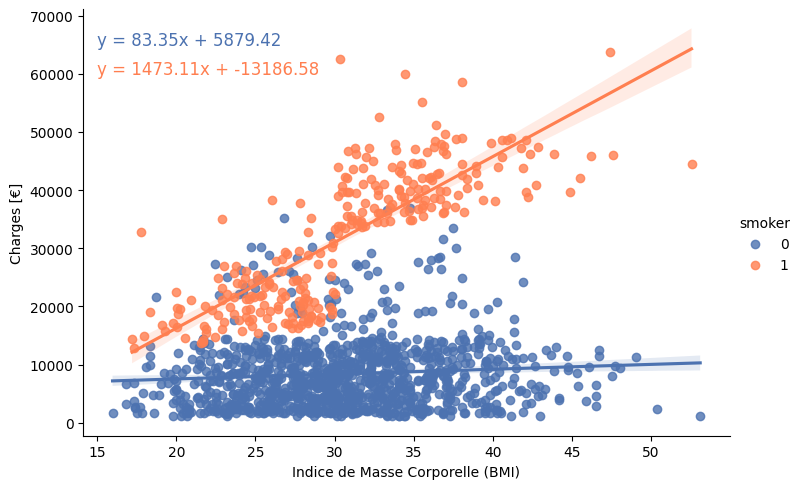

In [15]:
import numpy as np
sns.lmplot(x='bmi', y='charges', hue='smoker', data=data, aspect=1.5, height=5, palette={0: sns.color_palette("deep")[0], 1: 'coral'})

# Modifier la légende
# plt.legend(title='Fumeur', labels=['Non fumeur', 'Fumeur'])
# Filtrage des données pour les non-fumeurs et fumeurs
non_smoker_data = data[data['smoker'] == 0]
smoker_data = data[data['smoker'] == 1]


# Ajouter les titres des axes
plt.xlabel('Indice de Masse Corporelle (BMI)')
plt.ylabel('Charges [€]')




# Régression linéaire pour les non-fumeurs
non_smoker_slope, non_smoker_intercept = np.polyfit(non_smoker_data['bmi'], non_smoker_data['charges'], 1)

# Régression linéaire pour les fumeurs
smoker_slope, smoker_intercept = np.polyfit(smoker_data['bmi'], smoker_data['charges'], 1)

# Ajout du texte pour les pentes
# Ajouter l'équation des droites de régression
plt.text(15, 65000, f'y = {non_smoker_slope:.2f}x + {non_smoker_intercept:.2f}', fontsize=12, color=sns.color_palette("deep")[0])
plt.text(15, 60000, f'y = {smoker_slope:.2f}x + {smoker_intercept:.2f}', fontsize=12, color='coral')

plt.savefig(f'plots/bmi_charges_smoker', dpi=300)

# Afficher le plot
plt.show()


In [16]:
# Si l'ANOVA montre une différence significative, effectuer le test de Tukey
tukey_result = pairwise_tukeyhsd(
    endog=data["charges"], groups=data["smoker"], alpha=0.05
)
# print("\nRésultat du test de Tukey:\n", tukey_result)
tukey_result.summary()
# Visualisation des résultats
# tukey_result.plot_simultaneous()





group1,group2,meandiff,p-adj,lower,upper,reject
0,1,23615.9635,0.0,22623.1748,24608.7523,True


### Tests Chi2
_Utiliser entre deux variables catégorielles pour évaluer si elles sont indépendantes ou non_
- **H0**= Pas de relation significative entre les deux variables
 - **H1** = Il existe une relation significative entre les deux variables

--------------------------------------------------------
Tests : 
- **A** : Test entre les variables *enfants* et *fumeurs*.
- **B** : Test entre les variables *enfants* et *sexe*.
- **C** : Test entre les variables *sexe* et *fumeurs*.


In [17]:
from scipy.stats import chi2
def chi2_test(x1:str,x2:str,data:pd.DataFrame):
    contingency_table = pd.crosstab(data[x1], data[x2])
    chi2_statistic, p, dof, expected = chi2_contingency(contingency_table)

    # Calculer la valeur critique
    alpha = 0.05
    valeur_critique = chi2.ppf(1 - alpha, dof)

    print("Tableau de contingence :")
    print(contingency_table)
    print("\nRésultats du test chi2 :")
    print(f"Chi2 statistic = {chi2_statistic:.4f}")
    print(f"P-value = {p:.4e}")
    print(f"Degrés de liberté = {dof}")
    print("\nValeurs attendues sous l'hypothèse nulle :")
    print(expected)

    return {
        "contingency_table": contingency_table,
        "chi2_statistic": chi2,
        "p_value": p,
        "degrees_of_freedom": dof,
        "expected_values": expected,
        "critical_value": valeur_critique
    }

result = chi2_test('children', 'smoker', data)
if result['p_value'] > 0.05:
    print(f"critical value : {result['critical_value']}")
    print('H0 validée, les variable semblent indépendantes')
else:
    print('H0 rejetée, les variables semblent dépendantes')

Tableau de contingence :
smoker      0    1
children          
0         459  115
1         263   61
2         185   55
3         118   39
4          22    3
5          17    1

Résultats du test chi2 :
Chi2 statistic = 6.8877
P-value = 2.2913e-01
Degrés de liberté = 5

Valeurs attendues sous l'hypothèse nulle :
[[456.45440957 117.54559043]
 [257.65022422  66.34977578]
 [190.85201794  49.14798206]
 [124.8490284   32.1509716 ]
 [ 19.88041854   5.11958146]
 [ 14.31390135   3.68609865]]
critical value : 11.070497693516351
H0 validée, les variable semblent indépendantes


In [ ]:
result2 = chi2_test('children', 'masculin', data)
if result2['p_value'] > 0.05:
    print('H0 validée, les variable semblent indépendantes')
    print(f"critical value : {result['critical_value']}")
else:
    print('H0 rejetée, les variables semblent dépendantes')
    print(f"critical value : {result['critical_value']}")

Tableau de contingence :
masculin    0    1
children          
0         289  285
1         158  166
2         119  121
3          77   80
4          11   14
5           8   10

Résultats du test chi2 :
Chi2 statistic = 0.7352
P-value = 9.8098e-01
Degrés de liberté = 5

Valeurs attendues sous l'hypothèse nulle :
[[283.99701046 290.00298954]
 [160.30493274 163.69506726]
 [118.74439462 121.25560538]
 [ 77.67862481  79.32137519]
 [ 12.36920777  12.63079223]
 [  8.9058296    9.0941704 ]]
H0 validée, les variable semblent indépendantes


In [30]:
result3 = chi2_test('sex', 'smoker', df)
if result3['p_value'] > 0.05:
    print(f"critical value : {result['critical_value']}")
    print('H0 validée, les variable semblent indépendantes')
else:
    print(f"critical value : {result['critical_value']}")
    print('H0 rejetée, les variables semblent dépendantes')

Tableau de contingence :
smoker   no  yes
sex             
female  547  115
male    517  159

Résultats du test chi2 :
Chi2 statistic = 7.3929
P-value = 6.5481e-03
Degrés de liberté = 1

Valeurs attendues sous l'hypothèse nulle :
[[526.43348281 135.56651719]
 [537.56651719 138.43348281]]
critical value : 11.070497693516351
H0 rejetée, les variables semblent dépendantes


### Conclusion Chi2
- **A** : Test entre les variables *enfants* et *fumeurs* : <span style="color: red;"> indépendance </span> 
- **B** : Test entre les variables *enfants* et *sexe* :  <span style="color: red;"> indépendance </span> 
- **C** : Test entre les variables *sexe* et *fumeurs*  : <span style="color: green;"> dépendance</span> 

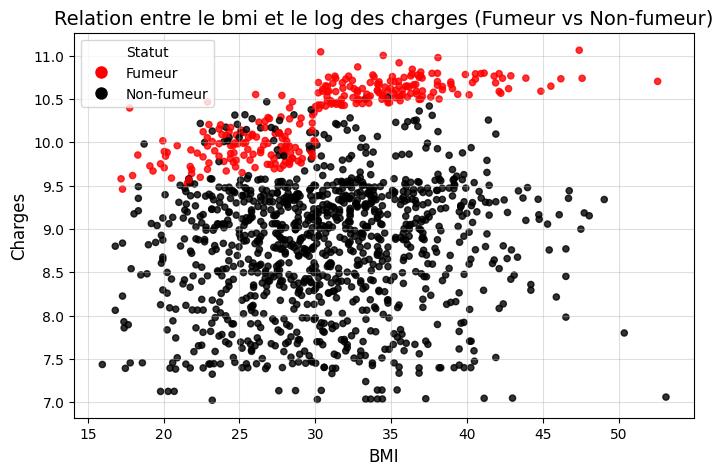

In [20]:
# Scatter plot
plt.figure(figsize=(8, 5))

# Couleurs pour les fumeurs et non-fumeurs
colors = data['smoker'].map({0: 'black', 1: 'red'})
labels = data['smoker'].map({0: 'Non-fumeur', 1: 'Fumeur'})

# Plot
scatter = plt.scatter(data['bmi'], np.log(data['charges']), c=colors, alpha=0.8, s=20)  # Taille des points réduite à 50

# Ajout des légendes
plt.title("Relation entre le bmi et le log des charges (Fumeur vs Non-fumeur)", fontsize=14)
plt.xlabel("BMI", fontsize=12)
plt.ylabel("Charges", fontsize=12)
plt.grid(alpha=0.4)

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color='w', label="Fumeur", markersize=10, markerfacecolor='red'),
           plt.Line2D([0], [0], marker='o', color='w', label="Non-fumeur", markersize=10, markerfacecolor='black')]
plt.legend(handles=handles, title="Statut", loc="upper left")

# Affichage
plt.show()

In [21]:
data.head()

,age,bmi,children,smoker,charges,masculin,feminin,southwest,northwest,northeast,southeast
0,19,27.900,0,1,16884.92400,0,1,1,0,0,0
1,18,33.770,1,0,1725.55230,1,0,0,0,0,1
2,28,33.000,3,0,4449.46200,1,0,0,0,0,1
3,33,22.705,0,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,0,3866.85520,1,0,0,1,0,0


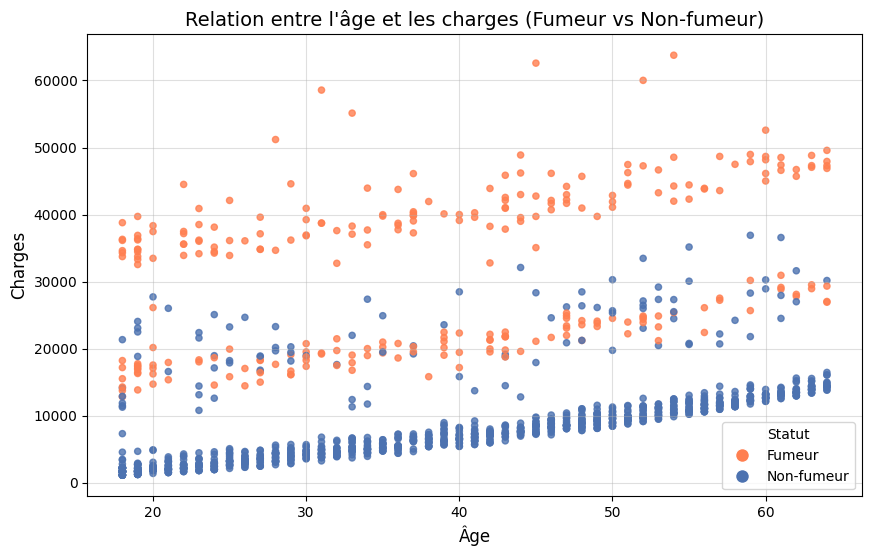

In [22]:
import seaborn as sns

# Scatter plot
plt.figure(figsize=(10, 6))

# Palette pour les fumeurs et non-fumeurs
palette = {0: sns.color_palette("deep")[0], 1: 'coral'}

# Couleurs pour les fumeurs et non-fumeurs
colors = data['smoker'].map(palette)

# Plot
scatter = plt.scatter(data['age'], data['charges'], c=colors, alpha=0.8, s=20)  # Taille des points réduite à 50

# # Ajout des courbes de régression linéaire
# sns.regplot(x='age', y='charges', data=data, scatter=False, 
#             line_kws={'color': 'blue', 'lw': 2, 'ls': '--'}, 
#             logistic=False, ci=None, color=sns.color_palette("deep")[0])

# sns.regplot(x='age', y='charges', data=data[data['smoker'] == 1], scatter=False, 
#             line_kws={'color': 'coral', 'lw': 2, 'ls': '--'}, 
#             logistic=False, ci=None, color='coral')



# Ajout des légendes
plt.title("Relation entre l'âge et les charges (Fumeur vs Non-fumeur)", fontsize=14)
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Charges", fontsize=12)
plt.grid(alpha=0.4)

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color='w', label="Fumeur", markersize=10, markerfacecolor='coral'),
           plt.Line2D([0], [0], marker='o', color='w', label="Non-fumeur", markersize=10, markerfacecolor=sns.color_palette("deep")[0])]
plt.legend(handles=handles, title="Statut", loc="lower right")

plt.savefig(f'plots/age_charges_smoker', dpi=300)

# Affichage
plt.show()

In [23]:
data.head()

,age,bmi,children,smoker,charges,masculin,feminin,southwest,northwest,northeast,southeast
0,19,27.900,0,1,16884.92400,0,1,1,0,0,0
1,18,33.770,1,0,1725.55230,1,0,0,0,0,1
2,28,33.000,3,0,4449.46200,1,0,0,0,0,1
3,33,22.705,0,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,0,3866.85520,1,0,0,1,0,0


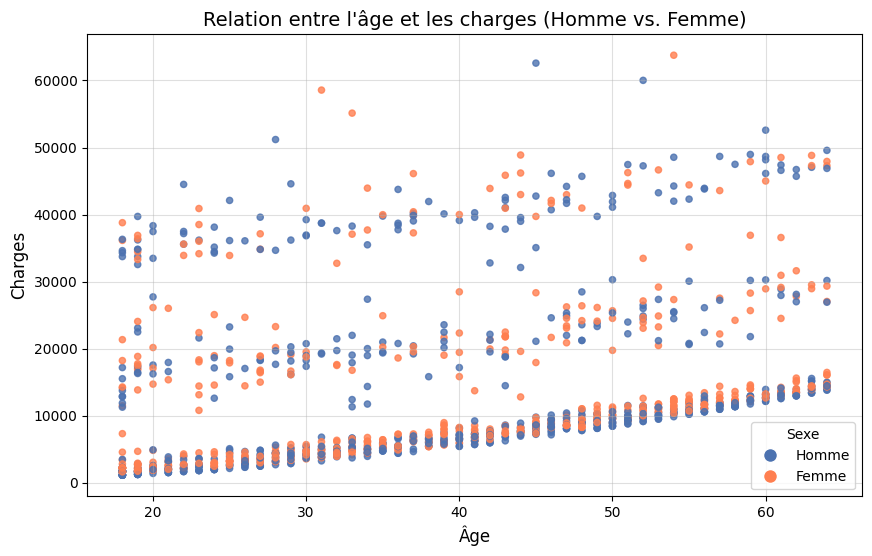

In [24]:
# Scatter plot
plt.figure(figsize=(10, 6))

# Palette pour les hommes et femmes
palette = {'male': sns.color_palette("deep")[0], 'female': 'coral'}

# Couleurs pour les hommes et femmes
colors = df['sex'].map(palette)

# Plot
scatter = plt.scatter(df['age'], df['charges'], c=colors, alpha=0.8, s=20)  # Taille des points réduite à 20

# Ajout des légendes
plt.title("Relation entre l'âge et les charges (Homme vs. Femme)", fontsize=14)
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Charges", fontsize=12)
plt.grid(alpha=0.4)

# Création de la légende
handles = [plt.Line2D([0], [0], marker='o', color='w', label="Homme", markersize=10, markerfacecolor=sns.color_palette("deep")[0]),
           plt.Line2D([0], [0], marker='o', color='w', label="Femme", markersize=10, markerfacecolor='coral')]
plt.legend(handles=handles, title="Sexe", loc="lower right")

plt.savefig(f'plots/age_charges_sex', dpi=300)

# Affichage
plt.show()

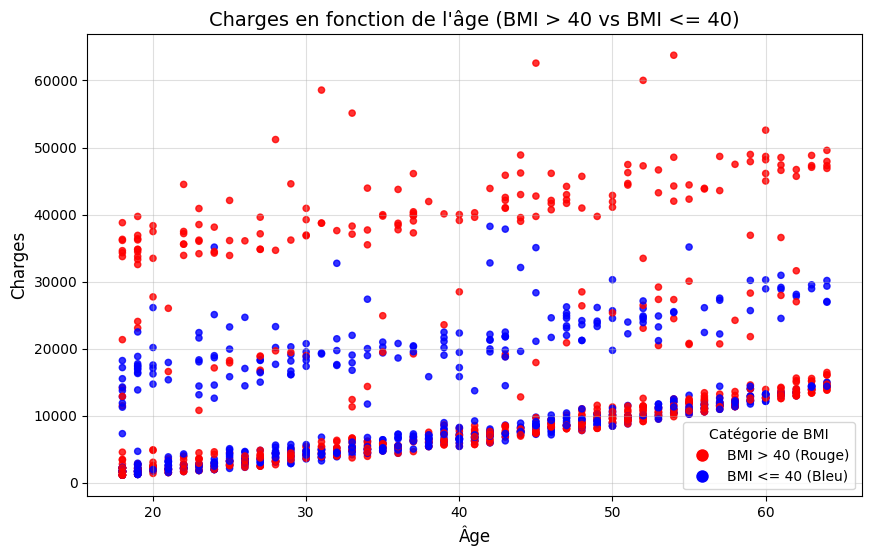

In [25]:
# Couleurs en fonction de BMI
colors = data['bmi'].apply(lambda x: 'red' if x > 30 else 'blue')

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['age'], data['charges'], c=colors, alpha=0.8, s=20)

# Ajout des titres et labels
plt.title("Charges en fonction de l'âge (BMI > 40 vs BMI <= 40)", fontsize=14)
plt.xlabel("Âge", fontsize=12)
plt.ylabel("Charges", fontsize=12)
plt.grid(alpha=0.4)

# Légende
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label="BMI > 40 (Rouge)", markersize=10, markerfacecolor='red'),
    plt.Line2D([0], [0], marker='o', color='w', label="BMI <= 40 (Bleu)", markersize=10, markerfacecolor='blue'),
]
plt.legend(handles=handles, title="Catégorie de BMI", loc="lower right")

# Affichage
plt.show()

In [26]:
stats.pearsonr(data["charges"], data["bmi"])

PearsonRResult(statistic=np.float64(0.1983409688336289), pvalue=np.float64(2.4590855351167345e-13))

In [27]:
# Catégorisation de la variable 'age'
data['age_category'] = pd.cut(
    data['age'],
    bins=[0, 25, 50, float('inf')],  # Bins : 0-25, 25-50, 50+
    labels=['<25', '25-50', '>50'],  # Noms des catégories
    right=False  # Inclure la borne inférieure dans chaque intervalle
)
data.head()

,age,bmi,children,smoker,charges,masculin,feminin,southwest,northwest,northeast,southeast,age_category
0,19,27.900,0,1,16884.92400,0,1,1,0,0,0,<25
1,18,33.770,1,0,1725.55230,1,0,0,0,0,1,<25
2,28,33.000,3,0,4449.46200,1,0,0,0,0,1,25-50
3,33,22.705,0,0,21984.47061,1,0,0,1,0,0,25-50
4,32,28.880,0,0,3866.85520,1,0,0,1,0,0,25-50


In [28]:
dbins_age = [0, 30 , 45, 60, np.inf]
label_age = ['jeune,'mature', 'agé, sénoir]
df['age_group'] = pd.cut(df['age'], bins = bins_age, label = label_age)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4117732964.py, line 2)

In [ ]:
mu_list = []
std_list = []

def normalize(df):
    # Créer une copie du DataFrame pour éviter de modifier l'original
    normalized_df = df.copy()
    
    # Listes pour stocker les moyennes et écarts types
    mu_list = []
    std_list = []
    
    # Normaliser les colonnes numériques
def normalize_data(data):
    print(data.shape[1])
    for i in range(0,data.shape[1]):
        mu = np.mean(data.iloc[1:,i])
        std = np.std(data.iloc[1:,i])
        data.iloc[:,i] = ((data.iloc[:,i] - mu)/std)
    return data

data2_ = normalize_data(data2)



12


/tmp/ipykernel_78305/3035946111.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      -1.440418
1      -1.511647
2      -0.799350
3      -0.443201
4      -0.514431
          ...   
1333    0.767704
1334   -1.511647
1335   -1.511647
1336   -1.297958
1337    1.551231
Name: age, Length: 1338, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:,i] = ((data.iloc[:,i] - mu)/std)
/tmp/ipykernel_78305/3035946111.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      -0.909234
1      -0.079442
2       1.580143
3      -0.909234
4      -0.909234
          ...   
1333    1.580143
1334   -0.909234
1335   -0.909234
1336   -0.909234
1337   -0.909234
Name: children, Length: 1338, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  da

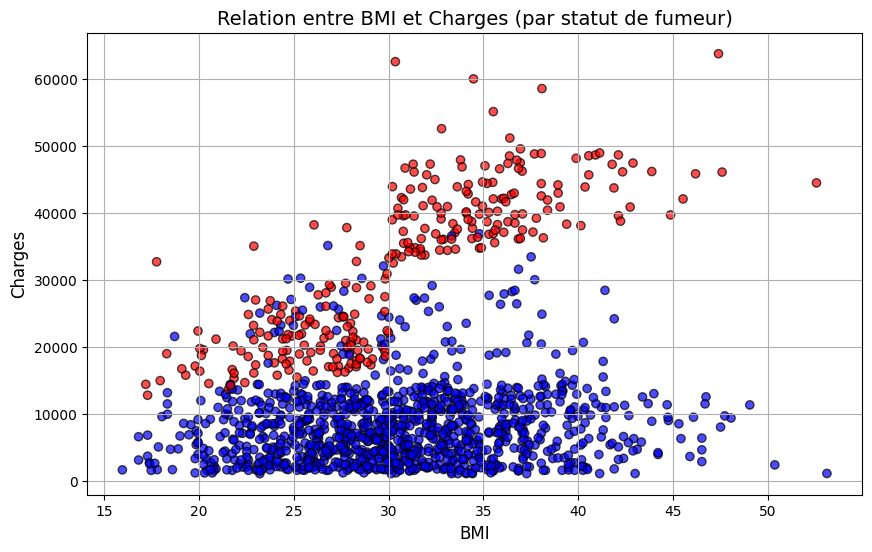

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))

# Définir les couleurs selon le statut de fumeur
colors = data['smoker'].map({'yes': 'red', 'no': 'blue'})

# Création du scatter plot
plt.scatter(data['bmi'], data['charges'], c=colors, alpha=0.7, edgecolors='k')

# Ajouter des légendes et des titres
plt.title('Relation entre BMI et Charges (par statut de fumeur)', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Charges', fontsize=12)
plt.grid(True)

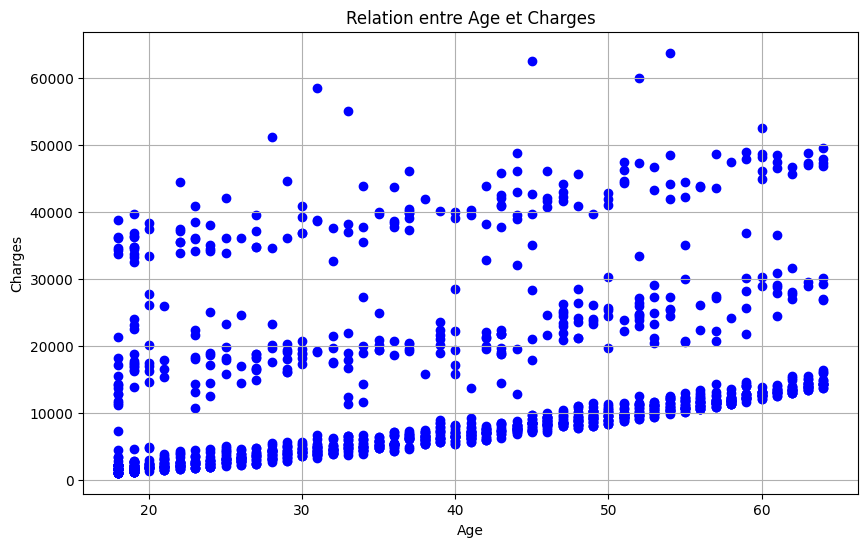

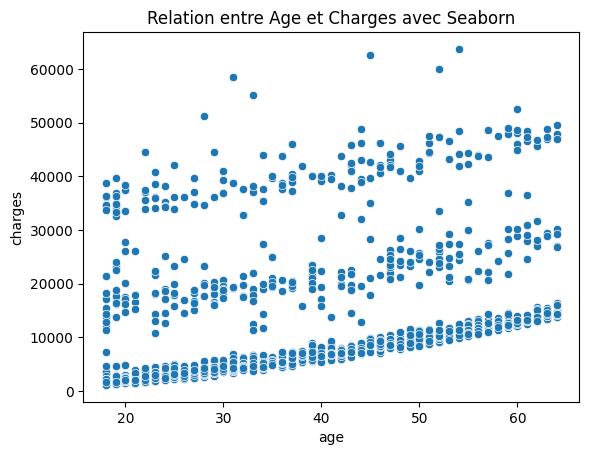

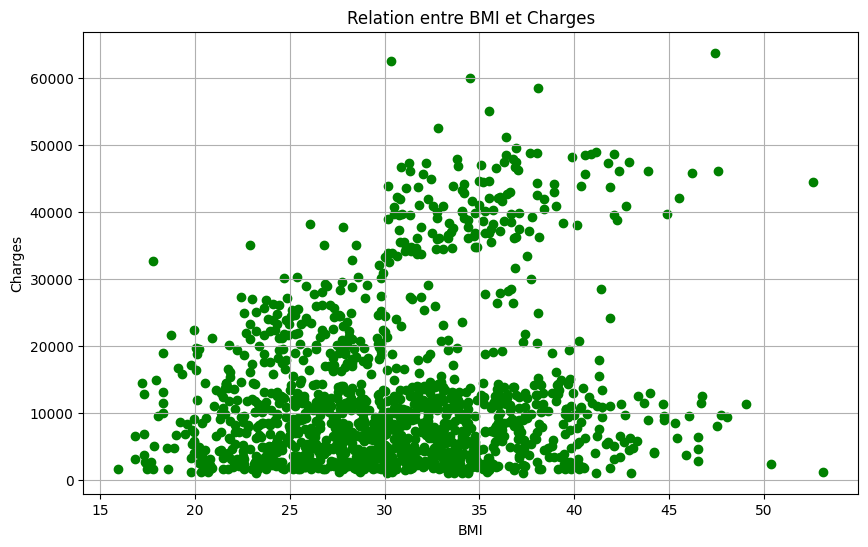

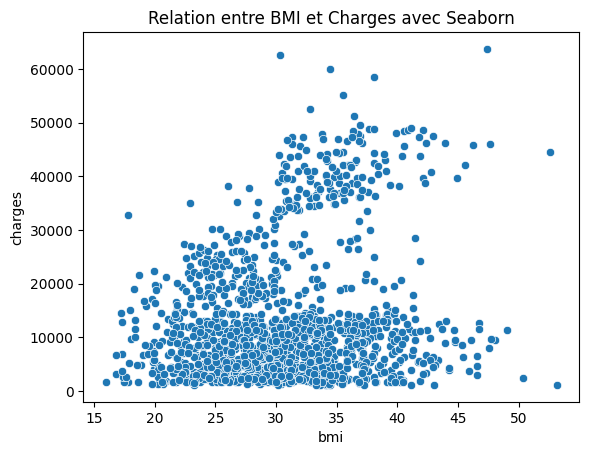

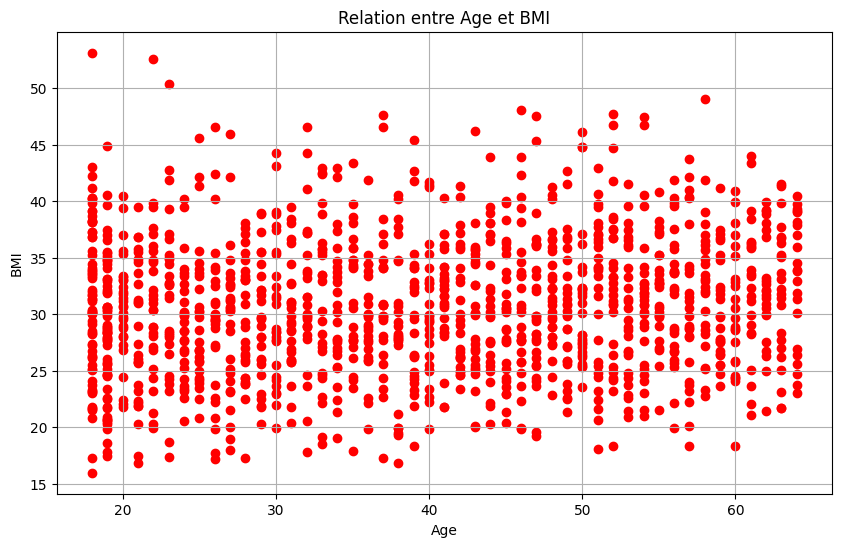

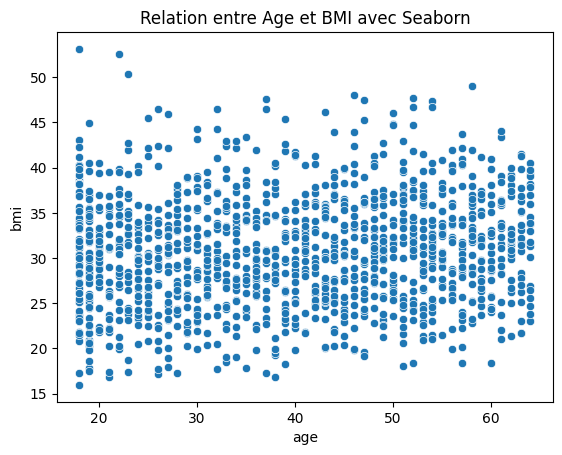

In [ ]:
# Scatter Plot avec Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['charges'], color='blue')
plt.title('Relation entre Age et Charges')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.grid(True)
plt.show()

# Scatter Plot avec Seaborn
sns.scatterplot(data=df, x='age', y='charges')
plt.title('Relation entre Age et Charges avec Seaborn')
plt.show()

# Scatter plot pour BMI et Charges
plt.figure(figsize=(10, 6))
plt.scatter(df['bmi'], df['charges'], color='green')
plt.title('Relation entre BMI et Charges')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.grid(True)
plt.show()
# AJOUT COULEUR POUR FUMEUR NON FUMEUR


# Scatter Plot avec Seaborn pour BMI et Charges
sns.scatterplot(data=df, x='bmi', y='charges')
plt.title('Relation entre BMI et Charges avec Seaborn')
plt.show()

# Scatter plot pour Age et BMI
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['bmi'], color='red')
plt.title('Relation entre Age et BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

# Scatter Plot avec Seaborn pour Age et BMI
sns.scatterplot(data=df, x='age', y='bmi')
plt.title('Relation entre Age et BMI avec Seaborn')
plt.show()

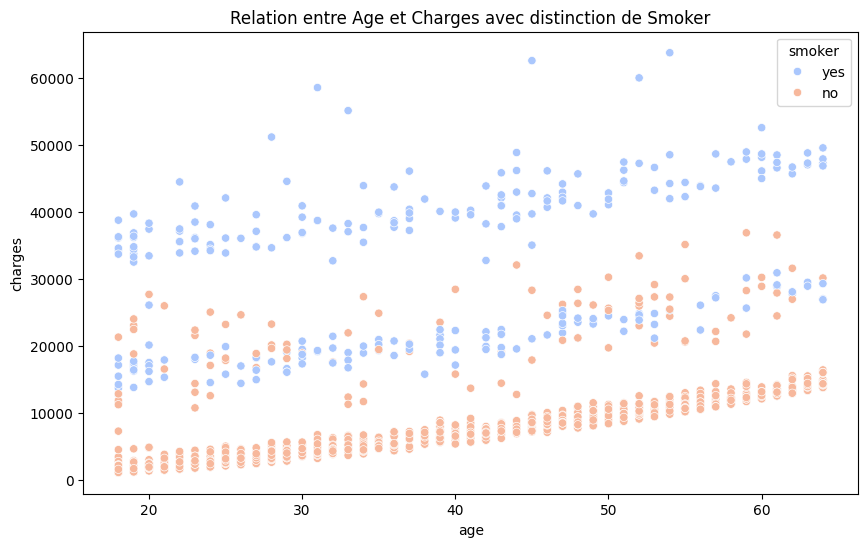

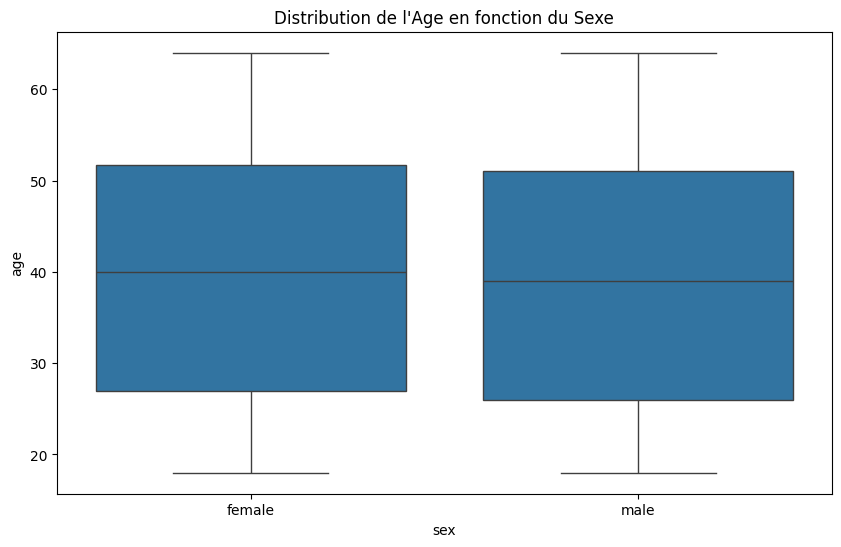

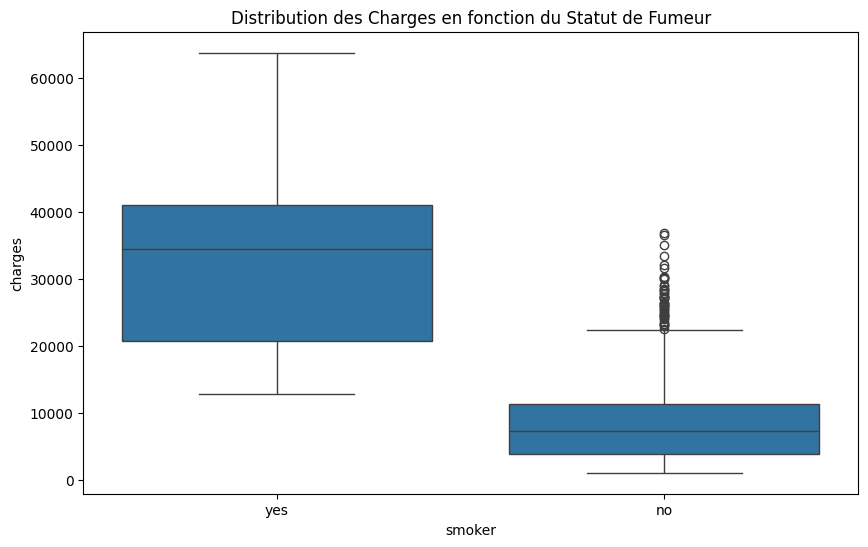

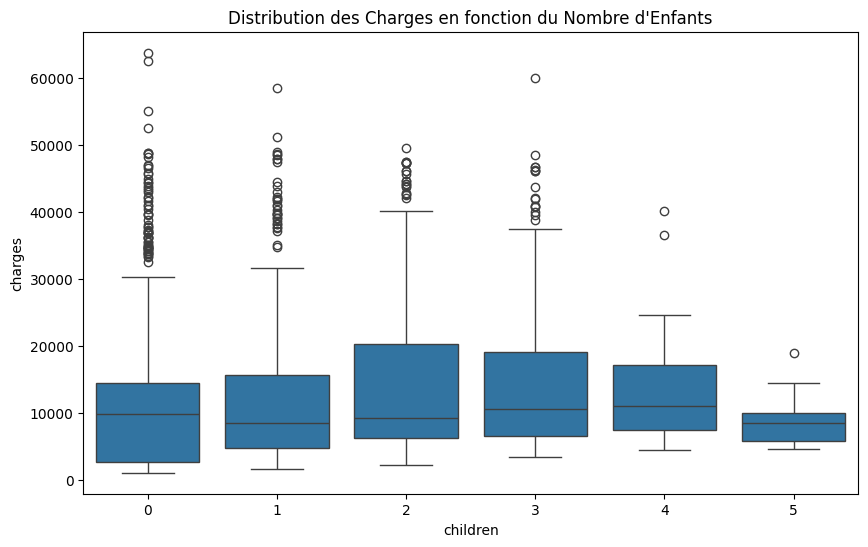

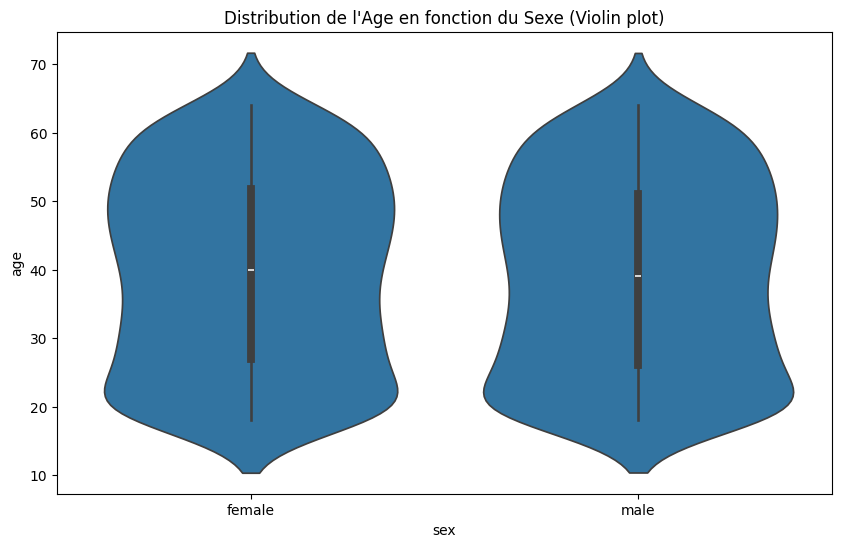

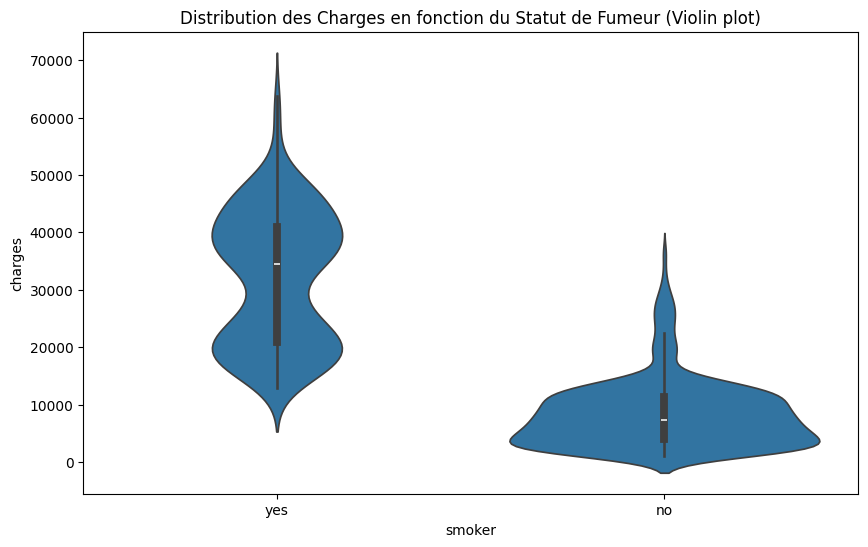

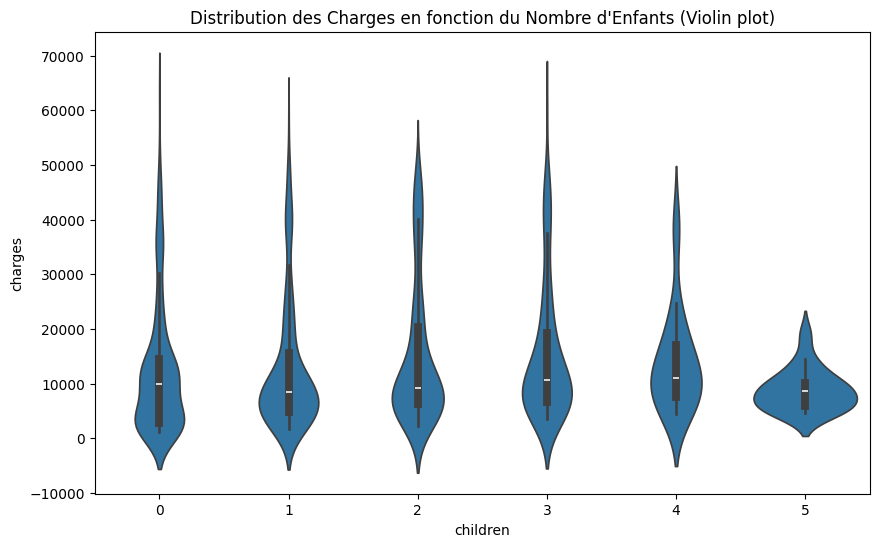

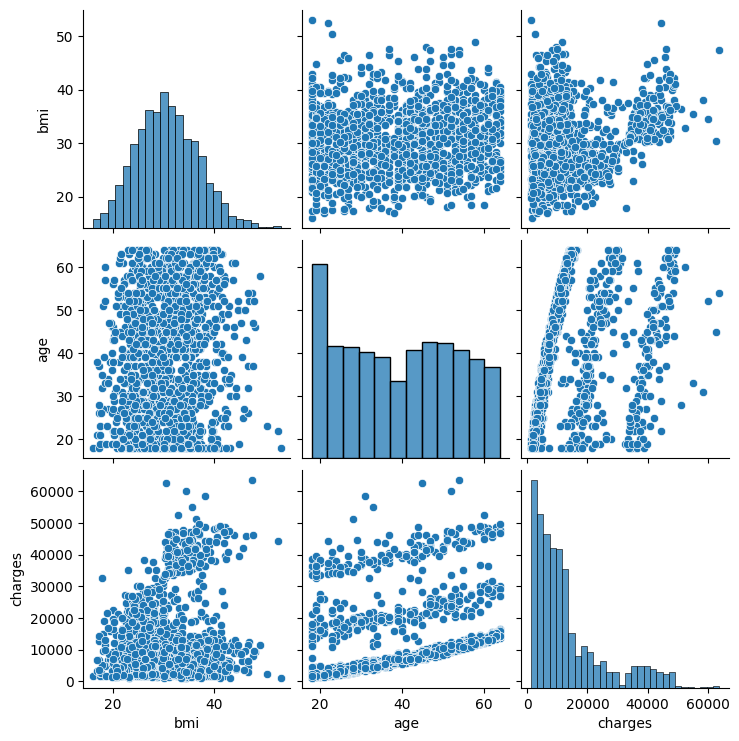

In [39]:
attributes = ['bmi', 'age', 'charges']
sns.pairplot(data[attributes])
plt.show()